In [1]:
import DataFunctions
import numpy as np

Overall idea of simulation: Do pairings taking into consideration current score (win-lose rate) and their geographical location. It will use an adaptation of the Swiss Pairing System, the main difference is that instead of participants having a ELO score or rating and being paired by it; we consider an objective function on the total distance travelled and find proper pairings that minimize it. 

Tentative Objective function: $\sum (d_i)^2 + max(d_i)^2$. This function uses L2 norm and a L2 regularization term. We have to consider a regularization term as it helps us to avoid having multiple low distances and 1 large distance. For simplicity we can remove the regularization to trial the algorithm, and then regularization.

Rules per each round:
1. Split teams by their current score (#wins)
2. Pair in groups from the highest scoring group to lowest scoring group.
3. Per each group, find the group of pairs that minimize the objective function.
4. If there are odd # of teams, demote unpaired team into next scoring group. If it has been demoted before, use the next possible pairing that includes that team.
5. If there exist unpaired teams, demote them into the next scoring group. 
6. After making all possible pairings, set distance of teams that are playing together to inf.
7. For each pairing, if both teams have the same # of home games, pick one to be home and one to be away randomly. If one team has more # home games than the other, pick the team with the least # home games to be home, the other to be the away.

Things to store in db:
1. Each team 2022 stats.
2. Each team # (from 0 to 131).
3. Simulated season pairings, w-l record and h-a count.
4. Simulated games and scores.

Simulating each pairing:
1. Use 2022 stats to predict a spread and totalpts. We use those as means.
2. Using a normal distribution on the spread and totalpts with the standard deviation found on the model. We randomly generate a result with the simulated spread and totalpts.
3. We use obtained values to create an score.

In [2]:
#creating random distance matrix of size = 8
nteams = 8

m_dist = np.around(np.random.uniform(1,10,size=(nteams,nteams)),decimals=3)

for i in range(nteams):
    for j in range(nteams):
        m_dist[j,i]=m_dist[i,j]
    m_dist[i,i]=0

m_dist

array([[0.   , 6.146, 6.313, 6.762, 9.007, 1.288, 5.288, 4.093],
       [6.146, 0.   , 4.542, 6.621, 3.775, 8.9  , 8.316, 3.104],
       [6.313, 4.542, 0.   , 2.888, 3.496, 7.464, 6.796, 9.555],
       [6.762, 6.621, 2.888, 0.   , 2.326, 5.348, 3.426, 6.321],
       [9.007, 3.775, 3.496, 2.326, 0.   , 6.692, 8.072, 5.354],
       [1.288, 8.9  , 7.464, 5.348, 6.692, 0.   , 8.366, 8.717],
       [5.288, 8.316, 6.796, 3.426, 8.072, 8.366, 0.   , 8.327],
       [4.093, 3.104, 9.555, 6.321, 5.354, 8.717, 8.327, 0.   ]])

In [3]:
#storing wins per team.
curr_data = np.zeros(shape=(nteams,3),dtype=int)
curr_data[:,0] = np.arange(nteams)
curr_data

array([[0, 0, 0],
       [1, 0, 0],
       [2, 0, 0],
       [3, 0, 0],
       [4, 0, 0],
       [5, 0, 0],
       [6, 0, 0],
       [7, 0, 0]])

In [4]:
#splitting in groups (need function here)
sim1group0 = np.array([x[0].astype(int) for x in curr_data if x[1]==0])
# sim1group1 = [[x[0].astype(int),0] for x in curr_data if x[1]==1]
sim1group0

array([0, 1, 2, 3, 4, 5, 6, 7])

We cannot find all pairs and run for all of them. That operation has time complexity O(n!) and for 130ish teams is not feasible as it is about $10^{220}$. We need to use another approach.<br>
Fastest approach is done by sorting all possible distances, then picking the suitable one and remove unsuitables from the list. We only need to sort once since at the beginning all teams have to play. We should also count the # of possible matches and use that to do the sorting as well.<br><br>

Algorithm procedure using networkx and Blossom algorithm (also known as Edmonds' algorithm)

In [5]:
import networkx as nx

In [6]:
L = []
G = nx.Graph()

for i in sim1group0:
    for j in sim1group0:
        if i<j: 
            L.append((i,j,m_dist[i,j]))

In [7]:
G.add_weighted_edges_from(L)

In [8]:
G.edges.data("weight")

EdgeDataView([(0, 1, 6.146), (0, 2, 6.313), (0, 3, 6.762), (0, 4, 9.007), (0, 5, 1.288), (0, 6, 5.288), (0, 7, 4.093), (1, 2, 4.542), (1, 3, 6.621), (1, 4, 3.775), (1, 5, 8.9), (1, 6, 8.316), (1, 7, 3.104), (2, 3, 2.888), (2, 4, 3.496), (2, 5, 7.464), (2, 6, 6.796), (2, 7, 9.555), (3, 4, 2.326), (3, 5, 5.348), (3, 6, 3.426), (3, 7, 6.321), (4, 5, 6.692), (4, 6, 8.072), (4, 7, 5.354), (5, 6, 8.366), (5, 7, 8.717), (6, 7, 8.327)])

In [9]:
matchings1g0 = nx.algorithms.matching.min_weight_matching(G)

In [10]:
LM = list(matchings1g0)
LM

[(1, 7), (5, 0), (4, 2), (3, 6)]

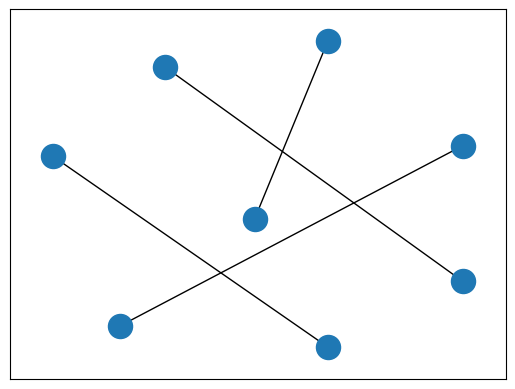

In [11]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos,edgelist=list(matchings1g0))

In [12]:
#checking 
m_dist[1,0],m_dist[4,6],m_dist[3,5],m_dist[2,7]

(6.146, 8.072, 5.348, 9.555)

In [13]:
LS = sorted(np.array(L)[:,2])
print(LS)

[1.288, 2.326, 2.888, 3.104, 3.426, 3.496, 3.775, 4.093, 4.542, 5.288, 5.348, 5.354, 6.146, 6.313, 6.321, 6.621, 6.692, 6.762, 6.796, 7.464, 8.072, 8.316, 8.327, 8.366, 8.717, 8.9, 9.007, 9.555]


In [14]:
set(sim1group0)-set(np.array(list(matchings1g0)).flatten()) 
# to find which one goes to the next group in odd cases 
# or those unpairable teams (team has played every other team)

set()

In [15]:
#merging all pairings
pairingssim1 = []
pairingssim1 +=matchings1g0
pairingssim1

#simulating matches
for g in pairingssim1:
    #home and away status
    if curr_data[g[0],2] == curr_data[g[1],2]:
        curr_data[g[np.random.randint(2)],2]+=1
    elif curr_data[g[0],2] > curr_data[g[1],2]:
        curr_data[g[1],2]+=1
    else:
        curr_data[g[0],2]+=1
    
    #simulating match
    if(np.random.randint(2)):
        curr_data[g[0],1] += 1
        print(g[0],"won")
        print(g[1],"lose")
    else:
        curr_data[g[1],1] += 1
        print(g[1],"won")
        print(g[0],"lose")
    # m_dist[g[0],g[1]]=0
    # m_dist[g[1],g[0]]=0
    G.remove_edge(u=g[0],v=g[1])

7 won
1 lose
0 won
5 lose
4 won
2 lose
6 won
3 lose


In [16]:
curr_data

array([[0, 1, 1],
       [1, 0, 0],
       [2, 0, 0],
       [3, 0, 1],
       [4, 1, 1],
       [5, 0, 0],
       [6, 1, 0],
       [7, 1, 1]])

In [17]:
#week 2
sim2 = [np.array([x[0].astype(int) for x in curr_data if x[1]==1]),
        np.array([x[0].astype(int) for x in curr_data if x[1]==0])]
sim2

[array([0, 4, 6, 7]), array([1, 2, 3, 5])]

In [18]:
Gs2g1 = G.subgraph(sim2[1])
Gs2g0 = G.subgraph(sim2[0])

In [19]:
matchings2g1 = nx.algorithms.matching.min_weight_matching(Gs2g1)
matchings2g0 = nx.algorithms.matching.min_weight_matching(Gs2g0)

In [20]:
list(matchings2g1),list(matchings2g0)

([(2, 1), (3, 5)], [(7, 4), (0, 6)])

In [21]:
#merging all pairings
pairingssim2 = []
pairingssim2 += matchings2g1
pairingssim2 += matchings2g0

#simulating matches
for g in pairingssim2:
    #home and away status
    if curr_data[g[0],2] == curr_data[g[1],2]:
        curr_data[g[np.random.randint(2)],2]+=1
    elif curr_data[g[0],2] > curr_data[g[1],2]:
        curr_data[g[1],2]+=1
    else:
        curr_data[g[0],2]+=1
    
    #simulating match
    if(np.random.randint(2)):
        curr_data[g[0],1] += 1
        print(g[0],"won")
        print(g[1],"lose")
    else:
        curr_data[g[1],1] += 1
        print(g[1],"won")
        print(g[0],"lose")
    # m_dist[g[0],g[1]]=0
    # m_dist[g[1],g[0]]=0
    G.remove_edge(u=g[0],v=g[1])

2 won
1 lose
3 won
5 lose
4 won
7 lose
0 won
6 lose


In [22]:
curr_data

array([[0, 2, 1],
       [1, 0, 1],
       [2, 1, 0],
       [3, 1, 1],
       [4, 2, 1],
       [5, 0, 1],
       [6, 1, 1],
       [7, 1, 2]])

In [23]:
#week 3
sim3 = [np.array([x[0].astype(int) for x in curr_data if x[1]==2]),
        np.array([x[0].astype(int) for x in curr_data if x[1]==1]),
        np.array([x[0].astype(int) for x in curr_data if x[1]==0])]
sim3

[array([0, 4]), array([2, 3, 6, 7]), array([1, 5])]

In [24]:
Gs3g2 = G.subgraph(sim3[2])
Gs3g1 = G.subgraph(sim3[1])
Gs3g0 = G.subgraph(sim3[0])

In [25]:
matchings3g2 = nx.algorithms.matching.min_weight_matching(Gs3g2)
matchings3g1 = nx.algorithms.matching.min_weight_matching(Gs3g1)
matchings3g0 = nx.algorithms.matching.min_weight_matching(Gs3g0)

In [26]:
#merging all pairings
pairingssim3 = []
pairingssim3 += matchings3g2
pairingssim3 += matchings3g1
pairingssim3 += matchings3g0

#simulating matches
for g in pairingssim3:
    #home and away status
    if curr_data[g[0],2] == curr_data[g[1],2]:
        curr_data[g[np.random.randint(2)],2]+=1
    elif curr_data[g[0],2] > curr_data[g[1],2]:
        curr_data[g[1],2]+=1
    else:
        curr_data[g[0],2]+=1
    
    #simulating match
    if(np.random.randint(2)):
        curr_data[g[0],1] += 1
        print(g[0],"won")
        print(g[1],"lose")
    else:
        curr_data[g[1],1] += 1
        print(g[1],"won")
        print(g[0],"lose")
    # m_dist[g[0],g[1]]=0
    # m_dist[g[1],g[0]]=0
    G.remove_edge(u=g[0],v=g[1])

1 won
5 lose
7 won
6 lose
2 won
3 lose
4 won
0 lose


In [27]:
curr_data

array([[0, 2, 1],
       [1, 1, 1],
       [2, 2, 1],
       [3, 1, 1],
       [4, 3, 2],
       [5, 0, 2],
       [6, 1, 2],
       [7, 2, 2]])

In [28]:
# now here we need the use of functions to be able to add TEAM 1 to group 2 and TEAM 5 to group 1 as they cannot be paired by themselves.
# for the first group, if there are issues then demote them, for the last group they have to ascend as the groups in the middle are larger.

In [29]:
# pending: make everything to functions.
# pending: Think on how to store games and their outcomes
# either database or simulated games on db and team record or game id.